In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import logging
import json
import os

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import Model, Input

from core.metrics import custom_acc
from core.losses import custom_cce
from core.astromer import get_ASTROMER
from core.data import load_records_v3

from presentation.experiments.exp_1_old import get_mlp, get_lstm, get_lstm_att, init_astromer


%load_ext autoreload
%autoreload 2

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
data_path = './data/records/alcock'
batch_size = 32

classes_name = pd.read_csv('{}/test_objs.csv'.format(data_path))['class'].unique()
classes_name = [c.replace('_', '\_') for c in classes_name]
num_cls = len(classes_name)
classes_name

train_batches = load_records_v3(os.path.join(data_path, 'train'),
                             batch_size,
                             max_obs=200,
                             repeat=4,
                             is_train=True,
                             num_cls=num_cls)

val_batches = load_records_v3(os.path.join(data_path, 'val'),
                           batch_size,
                           max_obs=200,
                           repeat=4,
                           is_train=True,
                             num_cls=num_cls)



Training Mode
Training Mode


In [4]:
list(classes_name)[0]

'Cep\\_0'

(3, 200, 1)
(3, 200, 1)
(9, 200, 1)
(5, 200, 1)
(6, 200, 1)
(6, 200, 1)


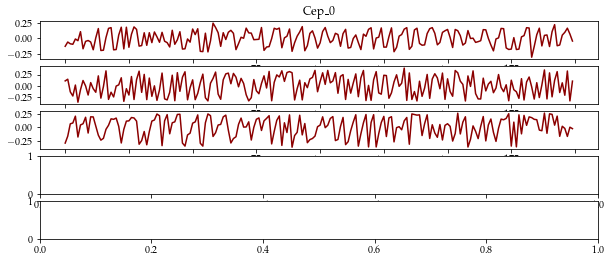

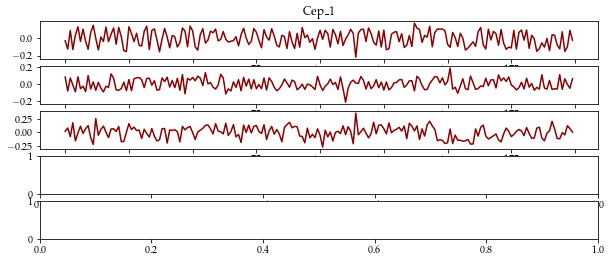

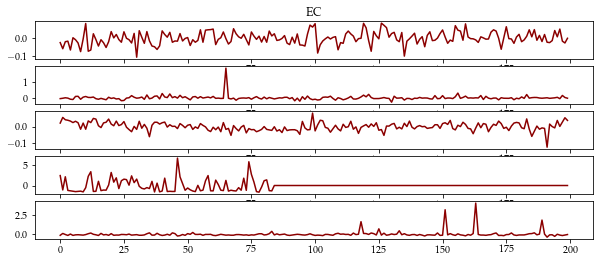

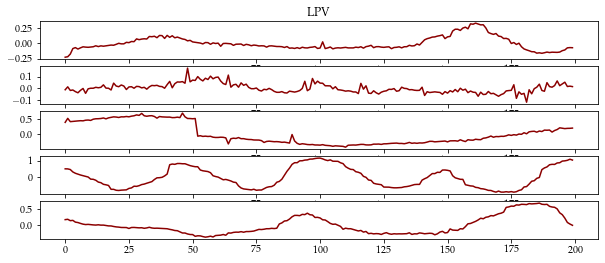

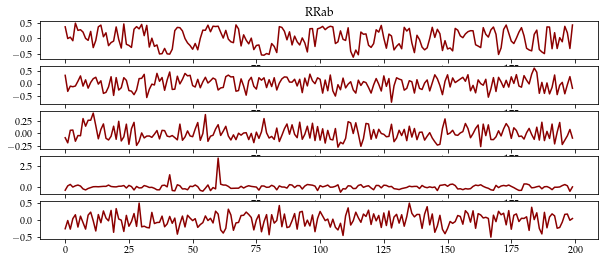

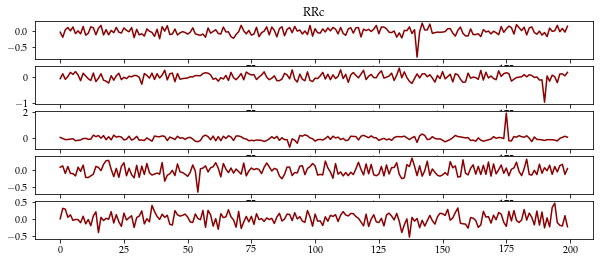

In [5]:
for batch, labels in train_batches:
    y = tf.argmax(labels, 1)
    for l in np.unique(y):
        x = batch['input'][y == l]  
        print(x.shape)
        fig, axes = plt.subplots(5, 1, figsize=(10,4))
        h = tf.minimum(5, x.shape[0])
        for i in range(h):
            axes[i].plot(x[i], color='darkred')
        axes[0].set_title('{}'.format(list(classes_name)[l]))
    break

In [6]:
weigths = './weights/astromer_10022021/finetuning/alcock'
encoder = init_astromer(weigths)

In [29]:
# model = get_mlp(num_cls, encoder)
# model = get_lstm(256, num_cls, 200, dropout=0.4)
model = get_lstm_att(256, num_cls, encoder=encoder, dropout=0.4)
model.summary()

Model: "LSTM_ATT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
times (InputLayer)              [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
encoder (Encoder)               (None, None, 256)    660736      input[0][0]                      
                                                                 mask[0][0]                

In [8]:
model.compile(optimizer=Adam(learning_rate=1e-2), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics='accuracy')

In [9]:
estop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [10]:
hist = model.fit(train_batches, 
                 epochs=2,
                 callbacks=[estop],
                 validation_data=val_batches)

Epoch 1/2


KeyboardInterrupt: 

In [ ]:
# model.save('model')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_loss'], label='Validation')
plt.plot(hist.history['loss'], label='Train')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.plot(hist.history['accuracy'], label='Train')
plt.legend()

In [ ]:
model.save('./my_model_500')

## Testing

In [ ]:
import tensorflow as tf
import h5py
import numpy as np

from sklearn.metrics import precision_recall_fscore_support



In [ ]:
cd /tf/astromer

In [ ]:
model = tf.keras.models.load_model('./my_model_500')

In [ ]:
metrics = []
for i in range(1, 6):
    with open('./alcock_emb/test_emb_{}.h5'.format(i), 'rb') as file:
        hf = h5py.File(file)
        x_test_time = hf['x'][()]
        y_test = hf['y'][()]
        l_test = hf['l'][()]
        m_test = 1. - hf['m'][()]
    n_classes = len(np.unique(y_test))
    x_test = np.sum(x_test_time*m_test, 1)/l_test[:,None]
    
    indices = np.random.randint(x_test.shape[0], size=750)
    x_test_reduced = x_test[indices]
    y_test_reduced = y_test[indices]
    
    y_pred = model.predict(x_test)
    y_pred_labs = tf.argmax(y_pred, 1)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_labs, average='macro')
    metrics.append([prec, rec, f1])

In [ ]:
np.mean(metrics, 0)

In [ ]:
np.std(metrics, 0)

In [ ]:

y_test_oneot = tf.one_hot(y_test, n_classes)

In [ ]:
import dask.dataframe as dd
import os

In [ ]:
batches = './data/embeddings/alcock_records'

In [ ]:
observations = dd.read_csv(os.path.join(batches,'*.csv'))

In [ ]:
observations.compute()